In [192]:
import spacy
import en_core_web_sm
import pandas as pd
import matplotlib.pyplot as plt

In [193]:
#load the part of speech tagger
nlp = en_core_web_sm.load()

In [377]:
df = pd.read_csv('data/Augmented_Data.csv')
df

,Text Command,Topic,Identifier,Action,One Hot Encoded Topic,One Hot Encoded Action,Verb/Noun
0,assign danger to design Track trends,Project,Track trends,Danger,"[0,1]","[0,0,0,1,0]",SYNREPLACED
1,project Track trends endorse on track,Project,Track trends,On Target,"[0,1]","[0,1,0,0,0]",SYNREPLACED
2,cast Track trends danger,Project,Track trends,Danger,"[0,1]","[0,0,0,1,0]",SYNREPLACED
3,started job Track trends,Task,Track trends,In Progress,"[1,0]","[0,1,0,0,0]",SYNREPLACED
4,Track trends is support in orbit,Project,Track trends,On Target,"[0,1]","[0,1,0,0,0]",SYNREPLACED
...,...,...,...,...,...,...,...
2968,labor Evaluate profit margins completed,Task,Evaluate profit margins,Completed,"[1,0]","[0,0,0,0,1]",SYNREPLACED
2969,started Evaluate profit margins job,Task,Evaluate profit margins,In Progress,"[1,0]","[0,1,0,0,0]",SYNREPLACED
2970,accomplished Evaluate profit margins,Task,Evaluate profit margins,Completed,"[1,0]","[0,0,0,0,1]",SYNREPLACED
2971,go Evaluate profit margins task,Task,Evaluate profit margins,In Progress,"[1,0]","[0,1,0,0,0]",SYNREPLACED


In [378]:
#create dataframe for adding tag data
identifier_pos = pd.DataFrame(columns = ['Text Command', 'Identifier', 'Tag Start', 'Tag End', 'First Tag', 'Last Tag'])

In [379]:
for i in df.index.values:
    #convert sentence into list of words with tags associated to each word
    sentence = nlp(df.loc[i][0])
    #create list of words that make up identifier
    identifier = df.loc[i][2].split()
    #first word in the identifier
    identifier_start = identifier[0]
    #last word in the identifier
    identifier_end = identifier[-1]
    #intialize the start of sentence tag
    last_word = nlp('SS')
    for token in last_word:
        #last word starts as SS token
        last_word = token
    #intialize the tag after the identifier as None
    tag_end = None
    #iterate through the words in the text command
    for j in range(len(sentence)):
        token = sentence[j]
        #if the word is equal to the first word in the identifer...
        if token.text == identifier_start:
            #if the last word variable is still the SS token then the tag that starts the identifier is the
            #start of the sentence
            if last_word.text == 'SS':
                tag_start = 'SS'
            #if not then the start tag is the POS tag of the last checked word
            else:
                tag_start = last_word.tag_
        #if the word is equal to the last word in the identifier...
        if last_word.text == identifier_end:
            tag_end = token.tag_
        #check the POS tag of the first word in the sentence
        if j == 0:
            if token.text == identifier_start:
                first_tag = 'ID'
            else:
                first_tag = token.tag_
        #check the POS tag of the last word in the sentence
        if j == len(sentence)-1:
            if token.text == identifier_end:
                last_tag = 'ID'
            else:
                last_tag = token.tag_
        #save the current word as last word for the above conditionals 
        last_word = token
    #if tag end hasn't been updated then we know that the identifier is at the end of the sentence
    if tag_end == None:
        tag_end = 'ES'
    identifier_pos.loc[i] = [df.loc[i][0], df.loc[i][2], tag_start, tag_end, first_tag, last_tag]


In [380]:
#intialize the dictionaries that contain counts of POS tags associated with text commands
tag_start_dict = dict()
tag_end_dict = dict()
tag_combo_dict = dict()
first_tag_dict = dict()
last_tag_dict = dict()
first_last_combo_dict = dict()
for i in range(len(identifier_pos.index)):
    tag_start = identifier_pos.loc[i][2]
    tag_end = identifier_pos.loc[i][3]
    #string combination of the two tags that the identifier is between
    tag_combo = tag_start + '-' + tag_end
    #POS tag of the first word in text command
    first_tag = identifier_pos.loc[i][4]
    last_tag = identifier_pos.loc[i][5]
    #string combination of first and last tag
    first_last_combo = first_tag + '-' + last_tag
    #update counts of text commands where POS tag indicates start of identifier
    if tag_start_dict.get(tag_start,0) == 0:
        tag_start_dict[tag_start] = 1
    else:
        tag_start_dict[tag_start] += 1
    #same thing but for end of identifier 
    if tag_end_dict.get(tag_end,0) == 0:
        tag_end_dict[tag_end] = 1
    else:
        tag_end_dict[tag_end] += 1
    #update counts of text commands where identifier is between combo of start and end POS tags
    if tag_combo_dict.get(tag_combo,0) == 0:
        tag_combo_dict[tag_combo] = 1
    else:
        tag_combo_dict[tag_combo] += 1
    #update counts of text commands with a nested dictionary. Keys in the outer dictionary are the POS tag assigned
    #to the first word in the text command. Key in the inner dictionary is the combo of start and end POS tags
    if first_tag_dict.get(first_tag,0) == 0:
        first_tag_dict[first_tag] = dict()
        first_tag_dict[first_tag][tag_combo] = 1
    else:
        if first_tag_dict[first_tag].get(tag_combo,0) == 0:
            first_tag_dict[first_tag][tag_combo] = 1
        else:
            first_tag_dict[first_tag][tag_combo] += 1
        tag_combo_dict[tag_combo] += 1
    #same for the last word in the text command
    if last_tag_dict.get(last_tag,0) == 0:
        last_tag_dict[last_tag] = dict()
        last_tag_dict[last_tag][tag_combo] = 1
    else:
        if last_tag_dict[last_tag].get(tag_combo,0) == 0:
            last_tag_dict[last_tag][tag_combo] = 1
        else:
            last_tag_dict[last_tag][tag_combo] += 1
    #same for the combo of the first and last word in the text command 
    if first_last_combo_dict.get(first_last_combo,0) == 0:
        first_last_combo_dict[first_last_combo] = dict()
        first_last_combo_dict[first_last_combo][tag_combo] = 1
    else:
        if first_last_combo_dict[first_last_combo].get(tag_combo,0) == 0:
            first_last_combo_dict[first_last_combo][tag_combo] = 1
        else:
            first_last_combo_dict[first_last_combo][tag_combo] += 1
            
    
    

In [381]:
#sorted dictionary of the text commands where the first and last words in the text command are nouns
sorted_combo_tag_dict = {k: v for k, v in sorted(first_last_combo_dict['NN-NN'].items(), key=lambda item: item[1],reverse=True)}

<BarContainer object of 12 artists>

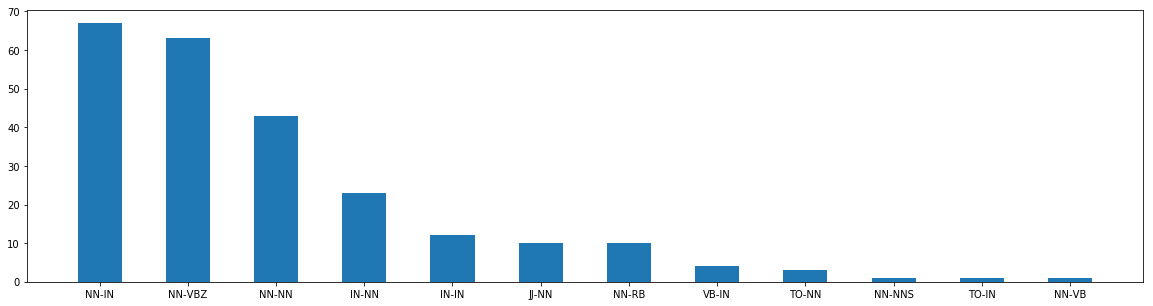

In [382]:
#visualize the number of text commands with a certain start end POS combo for the above condition
plt.figure(figsize=(20,5))
plt.bar(list(sorted_combo_tag_dict.keys()),list(sorted_combo_tag_dict.values()),width=0.5)

In [355]:
print(len(tag_combo_dict.keys()))

48


In [404]:
#applys the rule where if the text command starts and ends with a noun then we look for the first instance
#of a noun, then every word after is included in the identifier until a noun, preposition, or verb is found
def IdentifierIdentifier(pos_tagger,text_command):
    sentence = pos_tagger(text_command)
    first_tag = sentence[0].tag_
    last_tag = sentence[-1].tag_
    first_idx = None
    last_idx = None
    identifier_start = False
    if first_tag == 'NN' and last_tag == 'NN':
        for i in range(len(sentence)):
            tag = sentence[i].tag_
            if identifier_start and (tag == 'IN' or tag == 'VBZ' or tag == 'NN'):
                if tag == 'NN':
                    last_idx = i+1
                else:
                    last_idx = i
                break
            if not identifier_start and tag == 'NN':
                first_idx = i
                identifier_start = True
    identifier = sentence[first_idx+1:last_idx]
    return identifier

In [394]:
def print_tags(pos_tagger,text_command):
    sentence = pos_tagger(text_command)
    lst = []
    for word in sentence:
        lst.append(word.tag_)
    return str(sentence),lst

In [405]:
new_df = identifier_pos[(identifier_pos['Last Tag'] == 'NN') & (identifier_pos['First Tag'] == 'NN') & (identifier_pos['Tag Start'] == 'NN')]
count = 0
for i in new_df.index.values:
    text_command = new_df.loc[i][0]
    identifier = new_df.loc[i][1]
    predicted_identifier = IdentifierIdentifier(nlp, text_command)
    if str(predicted_identifier) == identifier:
        count += 1
    else:
        print(print_tags(nlp,text_command)[0] + ', '+str(print_tags(nlp,text_command)[1])+', ' + str(predicted_identifier))
print(count/len(new_df.index.values))

    

delegate project Track trends at risk, ['NN', 'NN', 'NNP', 'NNS', 'IN', 'NN'], project
job Track trends problem, ['NN', 'NNP', 'VBZ', 'NN'], Track
assign to job Track trends in review, ['NN', 'TO', 'NN', 'NNP', 'NNS', 'IN', 'NN'], to job
place project Track trends back on track, ['NN', 'NN', 'NNP', 'NNS', 'RB', 'IN', 'NN'], project
put task Track trends in review, ['NN', 'NN', 'NNP', 'NNS', 'IN', 'NN'], task
delegate task Track trends in progress, ['NN', 'NN', 'NNP', 'VBZ', 'IN', 'NN'], task
put plan Plan campaign at risk, ['NN', 'NN', 'NNP', 'NN', 'IN', 'NN'], plan
danger Plan campaign throw, ['NN', 'NN', 'NN', 'NN'], Plan
delegate to task Plan campaign in review, ['NN', 'IN', 'NN', 'NNP', 'NN', 'IN', 'NN'], 
attribute task Plan campaign in review, ['NN', 'NN', 'NNP', 'NN', 'IN', 'NN'], task
assign task Direct marketing in build, ['NN', 'NN', 'JJ', 'NN', 'IN', 'NN'], task
danger Market research design, ['NN', 'NN', 'NN', 'NN'], Market
place project Social media advertising at risk, ['

In [403]:
print_tags(nlp,'assign project Track trends to at risk')

('assign project Track trends to at risk',
 ['NNP', 'NN', 'NNP', 'NNS', 'IN', 'IN', 'NN'])